In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import fftpack
from scipy import signal

In [35]:
sampling_rate = 4000
gain = 12
v_ref = 4.5
resolution = (2**23) - 1

<AxesSubplot:xlabel='timestamp'>

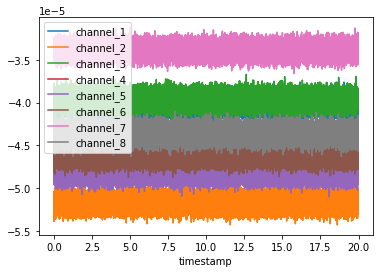

In [54]:
channel_offset = np.load('channel_offset_external.npy')
df = pd.DataFrame(data=channel_offset.T).set_index(0)
df = (df * v_ref) / resolution
df /= gain
df.columns = "channel_" + df.columns.astype(str)
df.index.name = "timestamp"
df.index -= min(df.index)
df.index /= 10**6
df.iloc[10:].plot()

In [32]:
channel_data_i = np.load('channel_data_shorted_external.npy')
df_i = pd.DataFrame(data=channel_data_i.T).set_index(0)
df_i = (df_i * v_ref) / resolution
df_i /= gain
df_i.columns = "channel_" + df_i.columns.astype(str)
df_i.index.name = "timestamp"
df_i.index -= min(df_i.index)
df_i.index /= 10**6

Text(0.5, 0, 'Time')

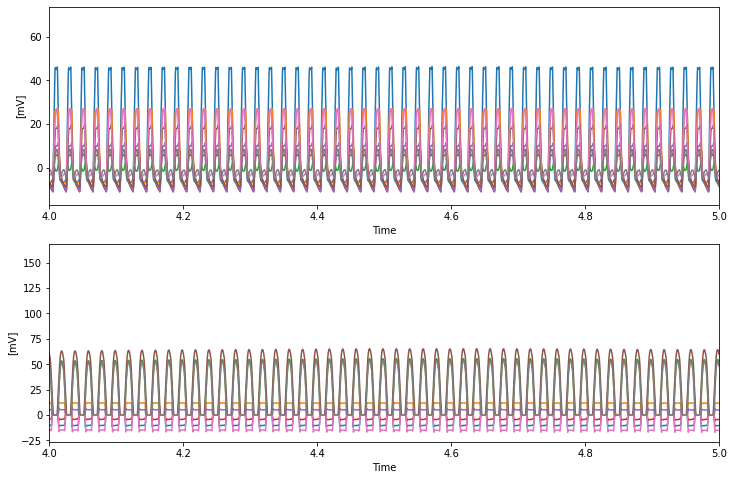

In [33]:
channel_data = np.load('old_data/channel_data.npy')
df = pd.DataFrame(data=channel_data.T).set_index(0)
df = (df * v_ref) / resolution
df /= gain
df.columns = "channel_" + df.columns.astype(str)
df.index.name = "timestamp"
df.index -= min(df.index)
df.index /= 10**6
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.plot(df_i.iloc[10:]*1000)
plt.xlim(4, 5)
plt.ylabel('[mV]')
plt.xlabel('Time')
plt.subplot(2, 1, 2)
plt.plot(df.iloc[10:]*1000)
plt.xlim(4, 5)
plt.ylabel('[mV]')
plt.xlabel('Time')


In [6]:
# Extract raw EMG signals and find FFT
y = df_i.channel_5
y = y.to_numpy()
y = y[1000:-3000]
y = y - y.mean()            # Center around zero

N = len(y)
T = 1 / sampling_rate
x = np.linspace(0.0, 1.0/(2.0*T), N//2)
y_fft = scipy.fftpack.fft(y)

Text(0, 0.5, 'Arbitrary unit')

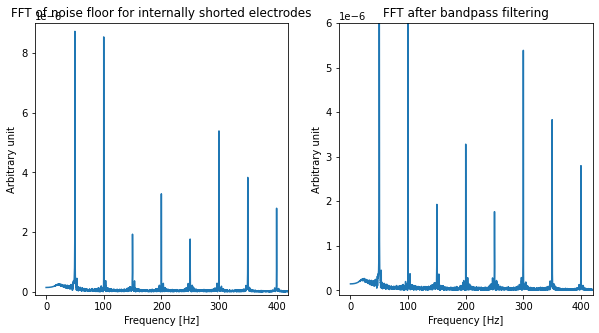

In [8]:
# Bandpass filter
high = 20        # Remove DC-related noise
low = 400       # EMG harmonics above 400Hz are generally due to noise
b, a = scipy.signal.butter(4, [high,low], btype='bandpass', fs=sampling_rate)
y_butter = scipy.signal.filtfilt(b, a, y)

N_butter = len(y_butter)
x_butter = np.linspace(0.0, 1.0/(2.0*T), N_butter//2)
y_butter_fft = scipy.fftpack.fft(y_butter)

fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
# plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
plt.plot(x_butter, 2.0/N_butter * np.abs(y_butter_fft[:N_butter//2]))
plt.xlim(-20, 420)
plt.ylim(-1e-7, 9e-6)
plt.title('FFT of noise floor for internally shorted electrodes')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Arbitrary unit')
plt.subplot(1, 2, 2)
plt.plot(x_butter, 2.0/N_butter * np.abs(y_butter_fft[:N_butter//2]))
plt.xlim(-20, 420)
plt.ylim(-1e-7, 6e-6)
plt.title('FFT after bandpass filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Arbitrary unit')


/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Arbitrary unit')

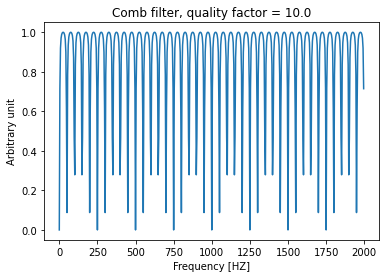

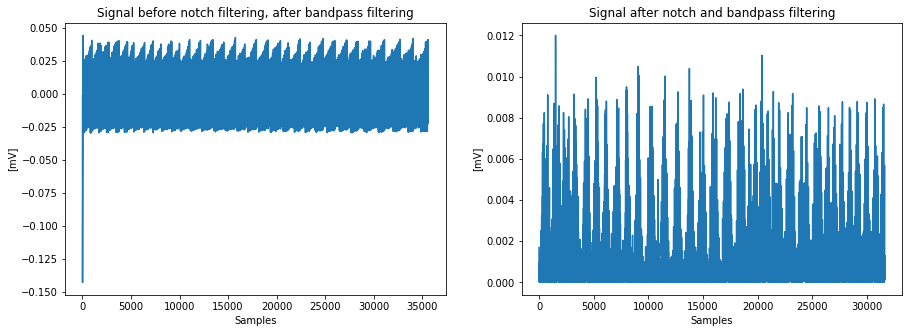

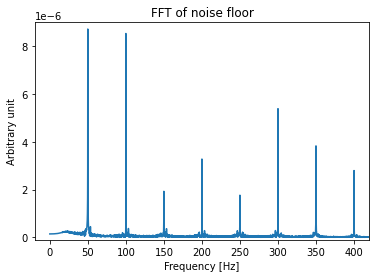

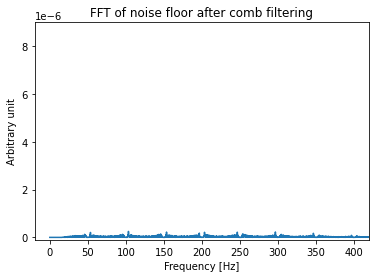

In [18]:
# Comb filter
notch_freq = 50.0     # Frequency to be removed from signal (Hz)
quality_factor = 10.0
b_notch, a_notch = scipy.signal.iircomb(w0=notch_freq, Q=quality_factor, fs=sampling_rate, ftype='notch')
freq, h = scipy.signal.freqz(b_notch, a_notch, fs=sampling_rate)
y_notched = scipy.signal.filtfilt(b_notch, a_notch, y_butter)



fig = plt.figure()
plt.plot(freq, h)
# plt.xlim(-20, 400)
plt.title('Comb filter, quality factor = ' + str(quality_factor))
plt.ylabel('Arbitrary unit')
plt.xlabel('Frequency [HZ]')

y_notched = y_notched[2000:-2000]

N_notched = len(y_notched)
x_notched = np.linspace(0.0, 1.0/(2.0*T), N_notched//2)
y_notched_fft = scipy.fftpack.fft(y_notched)


fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(y_butter*1000)
# plt.xlim(10000,12000)
plt.title('Signal before notch filtering, after bandpass filtering')
plt.ylabel('[mV]')
plt.xlabel('Samples')
plt.subplot(1, 2, 2)
plt.plot(abs(y_notched*1000))
# plt.xlim(6000, 9000)
plt.title('Signal after notch and bandpass filtering')
plt.ylabel('[mV]')
plt.xlabel('Samples')

fig = plt.figure()
plt.plot(x_butter, 2.0/N_butter * np.abs(y_butter_fft[:N_butter//2]))
plt.xlim(-20, 420)
plt.ylim(-1e-7, 9e-6)
plt.title('FFT of noise floor')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Arbitrary unit')

fig = plt.figure()
plt.plot(x_notched, 2.0/N_notched * np.abs(y_notched_fft[:N_notched//2]))
plt.xlim(-20, 420)
plt.ylim(-1e-7, 9e-6)
plt.title('FFT of noise floor after comb filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Arbitrary unit')

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Frequency [Hz]')

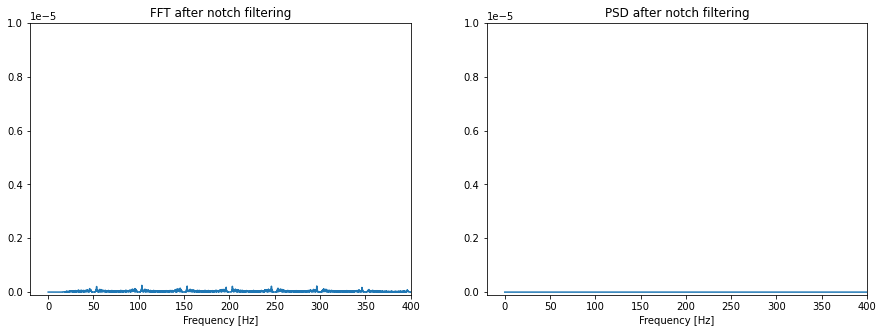

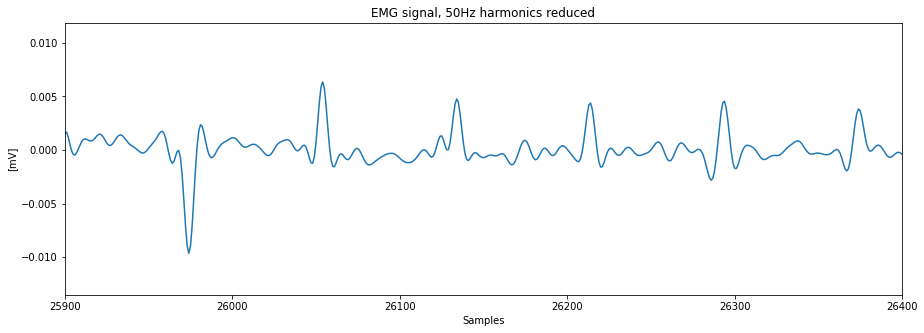

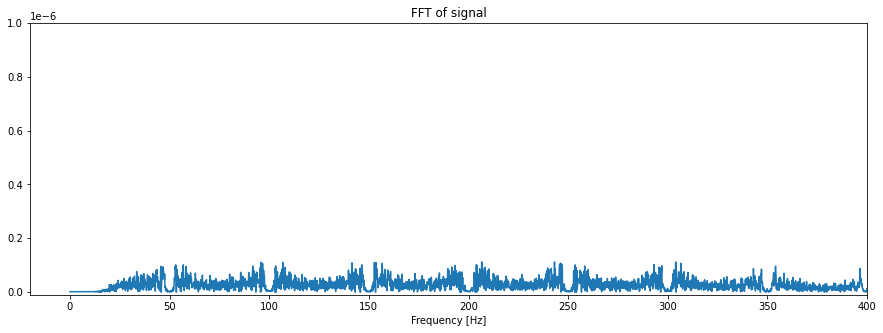

In [17]:
# Remove 50Hz harmonics from spectrum and transform back to time domain
psd = y_notched_fft * np.conj(y_notched_fft)/N_notched

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(x_notched, 2.0/N_notched * np.abs(y_notched_fft[:N_notched//2]))
plt.xlim(-20, 400)
plt.title('FFT after notch filtering')
plt.ylim(-1e-7, 1e-5)
plt.xlabel('Frequency [Hz]')
plt.subplot(1, 2, 2)
plt.plot(x_notched, 2.0/N_notched * np.abs(psd[:N_notched//2]))
plt.xlim(-20, 400)
plt.ylim(-1e-7, 1e-5)
plt.title('PSD after notch filtering')
plt.xlabel('Frequency [Hz]')

threshold = 1e-10
psd_idxs = psd < threshold
psd_clean = psd * psd_idxs
y_fft_clean = psd_idxs * y_notched_fft
y_clean = scipy.fftpack.ifft(y_fft_clean)

N_clean = len(y_clean)
x_clean = np.linspace(0.0, 1.0/(2.0*T), N_clean//2)

y_fft_clean = 2.0/N_clean * np.abs(y_fft_clean[:N_clean//2])
y_clean = y_clean[1000:-1000]
fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(y_clean*1000)
plt.xlim(25900,26400)
plt.title('EMG signal, 50Hz harmonics reduced')
plt.ylabel('[mV]')
plt.xlabel('Samples')
plt.subplot(1, 2, 2)
plt.plot(x_clean, y_fft_clean)
plt.xlim(-20, 400)
plt.ylim(-1e-8, 1e-6)
plt.title('FFT of signal')
plt.xlabel('Frequency [Hz]')

In [265]:
# Find noise floor
noise_data = np.load('channel_data_shorted_external.npy')
df_n = pd.DataFrame(data=noise_data.T).set_index(0)
df_n = (df_n * v_ref) / resolution
df_n /= gain
df_n.columns = "channel_" + df_n.columns.astype(str)
df_n.index.name = "timestamp"
df_n.index -= min(df_n.index)
df_n.index /= 10**6

noise = df_n.channel_1
noise = noise.to_numpy()
noise = noise - noise.mean()

# Bandpass filter
high = 20        # Remove DC-related noise
low = 400       # EMG harmonics above 400Hz are generally due to noise
b, a = scipy.signal.butter(4, [high,low], btype='bandpass', fs=sampling_rate)
noise = scipy.signal.filtfilt(b, a, noise)

# Comb filter
notch_freq = 50.0     # Frequency to be removed from signal (Hz)
quality_factor = 5.0
b_notch, a_notch = scipy.signal.iircomb(w0=notch_freq, Q=quality_factor, fs=sampling_rate, ftype='notch')
freq, h = scipy.signal.freqz(b_notch, a_notch, fs=sampling_rate)
noise = scipy.signal.filtfilt(b_notch, a_notch, noise)

In [266]:
# Calculate SNR
power_s = 1/(len(y_notched)) * np.abs(y_notched)**2
power_n = 1/(len(noise)) * np.abs(noise)**2
l = min(len(y_notched), len(noise))
power_s = power_s[:l]
power_n = power_n[:l]
snr = 10*np.log10((np.abs(power_s - power_n))/power_n)      # SNR in dB
snr.mean()

23.5071356171531